In [102]:
from mpi4py import MPI
from petsc4py import PETSc
import numpy as np
import pyvista
import matplotlib.pyplot as plt
import ufl

from dolfinx import default_scalar_type
from dolfinx.fem import Constant, Function, functionspace, assemble_scalar, dirichletbc, form, locate_dofs_geometrical, locate_dofs_topological, Expression
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc
from dolfinx.io import VTXWriter, XDMFFile
from dolfinx.mesh import create_unit_square, exterior_facet_indices, locate_entities_boundary, locate_entities, meshtags, Mesh
from dolfinx.plot import vtk_mesh
from basix.ufl import element
from ufl import (FacetNormal, Identity, TestFunction, TrialFunction, as_matrix,as_vector, SpatialCoordinate, Measure,
                 div, dot, ds, dx, inner, lhs, nabla_grad,grad, rhs, sym)

In [103]:
def error_L2(uh, u_ex, vector = True, degree_raise=4):
    # Create higher order function space
    degree = uh.function_space.ufl_element().degree
    family = uh.function_space.ufl_element().family_name
    mesh = uh.function_space.mesh
    velocity_element = element(family, mesh.topology.cell_name(), degree + degree_raise, shape=(mesh.geometry.dim, ))

    if vector:
        W = functionspace(mesh, velocity_element)
    else:
        W = functionspace(mesh,(family, degree + degree_raise))

    # Interpolate approximate solution
    u_W = Function(W)
    u_W.interpolate(uh)

    # Interpolate exact solution, special handling if exact solution
    # is a ufl expression or a python lambda function
    u_ex_W = Function(W)
    if isinstance(u_ex, ufl.core.expr.Expr):
        u_expr = Expression(u_ex, W.element.interpolation_points())
        u_ex_W.interpolate(u_expr)
    else:
        u_ex_W.interpolate(u_ex)

    # Compute the error in the higher order function space
    e_W = Function(W)
    e_W.x.array[:] = u_W.x.array - u_ex_W.x.array

    # Integrate the error
    error = form(ufl.inner(e_W, e_W) * ufl.dx)
    error_local = assemble_scalar(error)
    error_global = mesh.comm.allreduce(error_local, op=MPI.SUM)
    return np.sqrt(error_global)

In [104]:
def error_infinity(u_h, u_ex, vector = True):
    # Interpolate exact solution, special handling if exact solution
    # is a ufl expression or a python lambda function
    comm = u_h.function_space.mesh.comm
    u_ex_T = Function(u_h.function_space)
    if isinstance(u_ex, ufl.core.expr.Expr):
        u_expr = Expression(u_ex, u_h.function_space.element.interpolation_points())
        u_ex_T.interpolate(u_expr)
    else:
        u_ex_T.interpolate(u_ex)
    # Compute infinity norm, furst local to process, then gather the max
    # value over all processes
    error_max_local = np.max(np.abs(u_h.x.array - u_ex_T.x.array))
    error_max = comm.allreduce(error_max_local, op=MPI.MAX)
    return error_max

In [105]:
def run(grid_length, T , num_steps):
    #Domain and timestep definition
    mesh = create_unit_square(MPI.COMM_WORLD, grid_length, grid_length)
    t = 0
    dt = T / num_steps

    # Function Spaces
    v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim, ))
    s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
    V = functionspace(mesh, v_cg2)
    Q = functionspace(mesh, s_cg1)
    Vr, submap = V.sub(0).collapse()
    Vz, submap = V.sub(1).collapse() #Currently Unused
    # Trial and test functions 
    u = TrialFunction(V)
    v = TestFunction(V)
    p = TrialFunction(Q)
    q = TestFunction(Q)
    x = SpatialCoordinate(mesh)
    # Defining boundaries and creating tags for each boundary
    boundaries = [(1, lambda x: np.isclose(x[0], 0)),
                (2, lambda x: np.isclose(x[0], 1)),
                (3, lambda x: np.isclose(x[1], 0)),
                (4, lambda x: np.isclose(x[1], 1))]

    facet_indices, facet_markers = [], []
    fdim = mesh.topology.dim - 1
    for (marker, locator) in boundaries:
        facets = locate_entities(mesh, fdim, locator)
        facet_indices.append(facets)
        facet_markers.append(np.full_like(facets, marker))
    facet_indices = np.hstack(facet_indices).astype(np.int32)
    facet_markers = np.hstack(facet_markers).astype(np.int32)
    sorted_facets = np.argsort(facet_indices)
    facet_tag = meshtags(mesh, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

    mesh.topology.create_connectivity(mesh.topology.dim-1, mesh.topology.dim)

    ##### BOUNDARY CONDITIONS USED #####
    # Velocity Conditions
    sym_ur_dofs = locate_dofs_topological(V.sub(0),fdim,facet_tag.find(1))
    sym_ur = Function(Vr)
    sym_ur.interpolate(lambda x: 0*x[1])
    bc_sym_ur = dirichletbc(PETSc.ScalarType(0), sym_ur_dofs, V.sub(0))

    wall_dofs = locate_dofs_topological(V, fdim, facet_tag.find(2))
    u_noslip = np.array([0,0], dtype=PETSc.ScalarType)
    bc_noslip = dirichletbc(u_noslip, wall_dofs, V)

    # Pressure conditions
    inflow_dofs = locate_dofs_topological(Q, fdim, facet_tag.find(3))
    outflow_dofs = locate_dofs_topological(Q, fdim, facet_tag.find(4))
    bc_inflow = dirichletbc(PETSc.ScalarType(4), inflow_dofs, Q)
    bc_outflow = dirichletbc(PETSc.ScalarType(0), outflow_dofs, Q)
    ####################################

    ##### UNUSED BCs #####
    bot_ur_dofs = locate_dofs_topological((V.sub(0),Vr),fdim,facet_tag.find(3))
    bot_ur = Function(Vr)
    bot_ur.interpolate(lambda x: 0*x[1])
    bc_bot_ur = dirichletbc(bot_ur, bot_ur_dofs, V.sub(0))

    bot_uz_dofs = locate_dofs_topological((V.sub(1),Vz),fdim,facet_tag.find(3))
    bot_uz = Function(Vz)
    bot_uz.interpolate(lambda x:1-x[0]**2)
    bc_bot_uz = dirichletbc(bot_uz, bot_uz_dofs, V.sub(1))

    top_ur_dofs = locate_dofs_topological((V.sub(0),Vr),fdim,facet_tag.find(4))
    top_ur = Function(Vr)
    top_ur.interpolate(lambda x: 0*x[1])
    bc_top_ur = dirichletbc(top_ur, top_ur_dofs, V.sub(0))

    top_uz_dofs = locate_dofs_topological((V.sub(1),Vz),fdim,facet_tag.find(4))
    top_uz = Function(Vz)
    top_uz.interpolate(lambda x: 1-x[0]**2)
    bc_top_uz = dirichletbc(top_uz, top_uz_dofs, V.sub(1))

    wall_dofs = locate_dofs_topological(V, fdim, facet_tag.find(1))
    u_noslip = np.array([0,1], dtype=PETSc.ScalarType)
    bc_noslip_2 = dirichletbc(u_noslip, wall_dofs, V)

    sym_p_dofs = locate_dofs_topological(Q, fdim, facet_tag.find(1))
    sym_p = Function(Q)
    sym_p.interpolate(lambda x: 4-4*x[1])
    bc_sym_p = dirichletbc(sym_p, sym_p_dofs)

    wall_p_dofs = locate_dofs_topological(Q, fdim, facet_tag.find(1))
    wall_p = Function(Q)
    wall_p.interpolate(lambda x: 4-4*x[1])
    bc_wall_p = dirichletbc(wall_p, wall_p_dofs)

    ######################

    #Boundary uonditions used (sent to solver)
    bcu = [bc_noslip, bc_sym_ur]
    bcp = [bc_inflow, bc_outflow]
    # Defining IPCS parameters
    u_n = Function(V)
    u_n.name = "u_n"
    U = 0.5 * (u_n + u)
    n = FacetNormal(mesh)
    f= Constant(mesh, PETSc.ScalarType((0, 0)))
    k = Constant(mesh, PETSc.ScalarType(dt))
    mu = Constant(mesh, PETSc.ScalarType(0.000001))
    rho = Constant(mesh, PETSc.ScalarType(10000000))

    # Define stress tensor
    def epsilon(u):
        return sym(nabla_grad(u))

    def sigma(u, p):
        return 2 * mu * epsilon(u) - p * Identity(len(u))

    # hard encoded functions for 2D-Axisymmetric+
    x = SpatialCoordinate(mesh)
    def divergence_cyl(u):
        return u[0]+x[0]*u[0].dx(0)+x[0]*u[1].dx(1)
    def directional_deriv_cyl(u):
        return as_vector([u[0]*u[0].dx(0)+u[1]*u[0].dx(1),
                        u[0]*u[1].dx(0)+u[1]*u[1].dx(1)])
    def grad_3x3(u):
        return as_matrix([[u[0].dx(0), 0        , u[0].dx(1)],
                        [0         , u[0]/x[0], 0         ],
                        [u[1].dx(0), 0        , u[1].dx(1)]])
    def nabla_grad_3x3(u):
        return as_matrix([[u[0].dx(0), 0        , u[1].dx(0)],
                        [0         , u[0]/x[0], 0         ],
                        [u[0].dx(1), 0        , u[1].dx(1)]])
    two = Constant(mesh, PETSc.ScalarType(2))
    def explicit_product(u,v,p):
        return mu*(two*u[0]*v[0]/x[0]**2+two*u[0].dx(0)*v[0].dx(0)+two*u[1].dx(1)*v[1].dx(1)+
                                      u[0].dx(1)*v[0].dx(1)+    u[1].dx(0)*v[1].dx(0)+
                                      u[0].dx(1)*v[1].dx(0)+    u[1].dx(0)*v[0].dx(1))
               

    # Define the variational problem for the first step
    #ds = Measure("ds", domain=mesh)
    p_n = Function(Q)
    p_n.name = "p_n"
    F1 = rho * dot((u - u_n) / k, v) *x[0]* dx
    F1 +=  rho * dot(directional_deriv_cyl(u_n), v) *x[0]* dx
    F1 += inner( mu *(nabla_grad_3x3(U)+grad_3x3(U)) , grad_3x3(v))*x[0]*dx
    #F1 += explicit_product(u,v,p)*x[0]*dx
    F1 += -p_n*divergence_cyl(v)*dx
    

    F1 += dot(p_n * n, v) *x[0]* ds - dot(mu * nabla_grad(U) * n, v) *x[0]* ds

    ##### CODE FOR BOUNDARY SPLITTING (UNUSED) #####

    #ds = Measure("ds", domain=mesh, subdomain_data=facet_tag)
    #F1 += dot(p_n * n, v) *x[0]* ds(1) - dot(mu * nabla_grad(U) * n, v) *x[0]* ds(1)
    #F1 += dot(p_n * n, v) *x[0]* ds(2) - dot(mu * nabla_grad(U) * n, v) *x[0]* ds(2)
    #F1 += dot(p_n * n, v) *x[0]* ds(3) - dot(mu * nabla_grad(U) * n, v) *x[0]* ds(3)
    #F1 += dot(p_n * n, v) *x[0]* ds(4) - dot(mu * nabla_grad(U) * n, v) *x[0]* ds(4)

    ################################################

    F1 -= dot(f, v) *x[0]* dx

    # 
    a1 = form(lhs(F1))
    L1 = form(rhs(F1))

    A1 = assemble_matrix(a1, bcs=bcu)
    A1.assemble()
    b1 = create_vector(L1)

    # Define variational problem for step 2
    u_ = Function(V)
    a2 = form(dot(nabla_grad(p), nabla_grad(q)) *x[0]* dx)
    L2 = form(dot(nabla_grad(p_n), nabla_grad(q)) *x[0]* dx- (rho / k) *divergence_cyl(u_)*q* dx)
    A2 = assemble_matrix(a2, bcs=bcp)
    A2.assemble()
    b2 = create_vector(L2)

    # Define variational problem for step 3
    p_ = Function(Q)
    a3 = form(rho * dot(u, v) *x[0]* dx)
    L3 = form(rho * dot(u_, v) *x[0]* dx - k * dot(nabla_grad(p_ - p_n), v) *x[0]* dx)
    A3 = assemble_matrix(a3)
    A3.assemble()
    b3 = create_vector(L3)

    # Solver for step 1
    solver1 = PETSc.KSP().create(mesh.comm)
    solver1.setOperators(A1)
    solver1.setType(PETSc.KSP.Type.BCGS)
    pc1 = solver1.getPC()
    pc1.setType(PETSc.PC.Type.HYPRE)
    pc1.setHYPREType("boomeramg")

    # Solver for step 2
    solver2 = PETSc.KSP().create(mesh.comm)
    solver2.setOperators(A2)
    solver2.setType(PETSc.KSP.Type.BCGS)
    pc2 = solver2.getPC()
    pc2.setType(PETSc.PC.Type.HYPRE)
    pc2.setHYPREType("boomeramg")

    # Solver for step 3
    solver3 = PETSc.KSP().create(mesh.comm)
    solver3.setOperators(A3)
    solver3.setType(PETSc.KSP.Type.CG)
    pc3 = solver3.getPC()
    pc3.setType(PETSc.PC.Type.SOR)

    def u_exact(x):
        values = np.zeros((2, x.shape[1]), dtype=PETSc.ScalarType)
        values[1] = 1.0-x[0]**2
        return values
    def p_exact(x):
        return 4-4*x[1]

    ## TIME LOOP ##

    for i in range(num_steps):
        # Update current time step
        t += dt

        # Step 1: Tentative veolcity step
        with b1.localForm() as loc_1:
            loc_1.set(0)
        assemble_vector(b1, L1)
        apply_lifting(b1, [a1], [bcu])
        b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b1, bcu)
        solver1.solve(b1, u_.x.petsc_vec)
        u_.x.scatter_forward()

        # Step 2: Pressure corrrection step
        with b2.localForm() as loc_2:
            loc_2.set(0)
        assemble_vector(b2, L2)
        apply_lifting(b2, [a2], [bcp])
        b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b2, bcp)
        solver2.solve(b2, p_.x.petsc_vec)
        p_.x.scatter_forward()

        # Step 3: Velocity correction step
        with b3.localForm() as loc_3:
            loc_3.set(0)
        assemble_vector(b3, L3)
        b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        solver3.solve(b3, u_.x.petsc_vec)
        u_.x.scatter_forward()

        # Update variable with solution form this time step
        u_n.x.array[:] = u_.x.array[:]
        p_n.x.array[:] = p_.x.array[:]

    b1.destroy()
    b2.destroy()
    b3.destroy()
    solver1.destroy()
    solver2.destroy()
    solver3.destroy()

    return error_L2(u_n, u_exact), error_infinity(u_n, u_exact), error_L2(p_n, p_exact, False), error_infinity(p_n, p_exact, False)
    

In [106]:
##### META LOOP FOR CONVERGENCE TESTING #####
grid_length_max = 30
grid_length_range = range(5,grid_length_max+1, 2)
L2_error_u_list = []
max_error_u_list = []
L2_error_p_list = []
max_error_p_list = []

for grid_length in grid_length_range:
    print(grid_length)
    
    L2_error_u, max_error_u, L2_error_p, max_error_p  = run(grid_length, 4, 10000)
    print(f"L2-error u {L2_error_u:.2e}, Max error u {max_error_u:.2e}")
    print(f"L2-error p {L2_error_p:.2e}, Max error p {max_error_p:.2e}")
    L2_error_u_list.append(L2_error_u)
    max_error_u_list.append(max_error_u)
    L2_error_p_list.append(L2_error_p)
    max_error_p_list.append(max_error_p)

    

5
L2-error u 7.30e-01, Max error u 1.00e+00
L2-error p 3.29e-03, Max error p 1.79e-02
7
L2-error u 7.30e-01, Max error u 1.00e+00
L2-error p 2.15e-03, Max error p 1.34e-02
9
L2-error u 7.30e-01, Max error u 1.00e+00
L2-error p 1.72e-03, Max error p 1.05e-02
11
L2-error u 7.30e-01, Max error u 1.00e+00
L2-error p 1.46e-03, Max error p 8.56e-03
13
L2-error u 7.30e-01, Max error u 1.00e+00
L2-error p 1.26e-03, Max error p 7.13e-03
15
L2-error u 7.30e-01, Max error u 1.00e+00
L2-error p 1.12e-03, Max error p 6.07e-03
17
L2-error u 7.30e-01, Max error u 1.00e+00
L2-error p 9.90e-04, Max error p 5.25e-03
19
L2-error u 7.30e-01, Max error u 1.00e+00
L2-error p 8.84e-04, Max error p 4.86e-03
21
L2-error u 7.30e-01, Max error u 1.00e+00
L2-error p 7.97e-04, Max error p 4.83e-03
23
L2-error u 7.30e-01, Max error u 1.00e+00
L2-error p 7.20e-04, Max error p 4.73e-03
25
L2-error u 7.30e-01, Max error u 1.00e+00
L2-error p 6.51e-04, Max error p 4.65e-03
27
L2-error u 7.30e-01, Max error u 1.00e+00
L

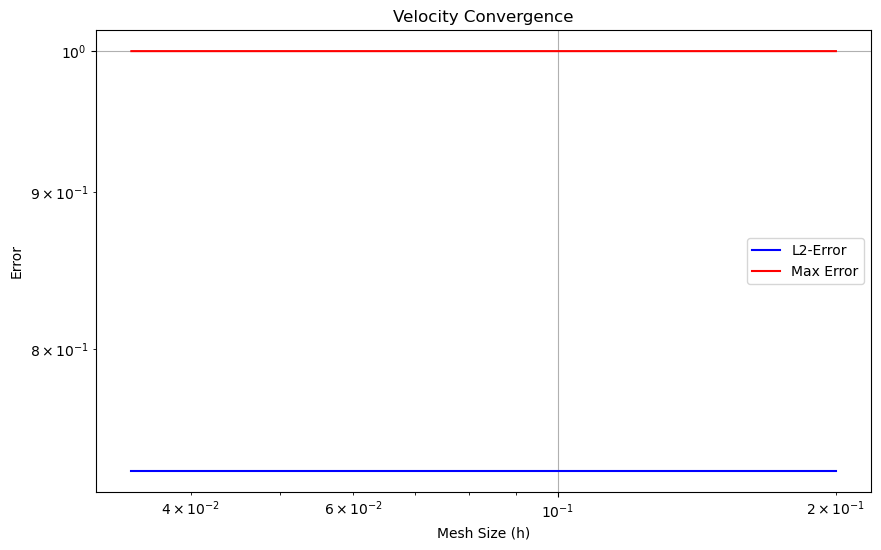

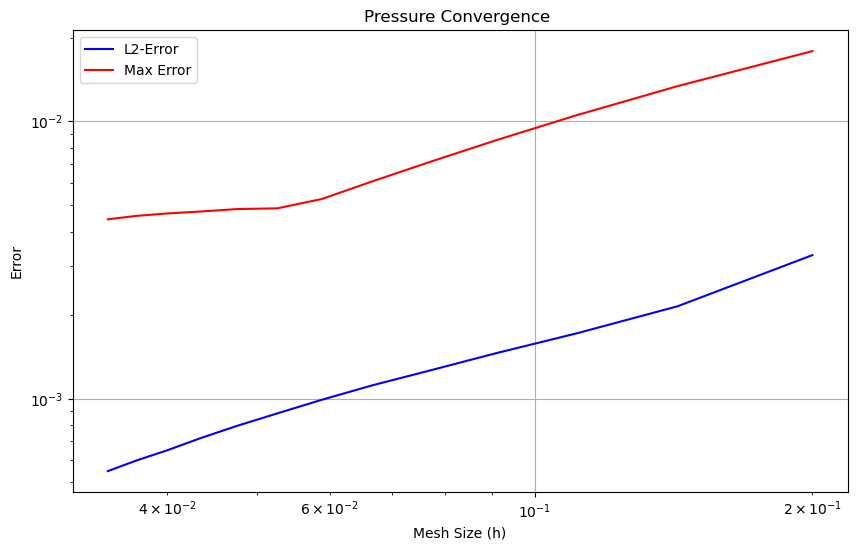

In [107]:
h = np.flip([1/x for x in grid_length_range])

plt.figure(figsize =(10 , 6))
plt.plot(h,np.flip(L2_error_u_list), 'b', label ='L2-Error')
plt.plot(h,np.flip(max_error_u_list), 'r', label ="Max Error")
plt.xlabel('Mesh Size (h)')
plt.ylabel('Error')
plt.yscale('log')
plt.xscale('log')

plt.title('Velocity Convergence')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize =(10 , 6))
plt.plot(h,np.flip(L2_error_p_list), 'b', label ='L2-Error')
plt.plot(h,np.flip(max_error_p_list), 'r', label ="Max Error")
plt.xlabel('Mesh Size (h)')
plt.ylabel('Error')
plt.yscale('log')
plt.xscale('log')

plt.title('Pressure Convergence ')
plt.legend()
plt.grid(True)
plt.show()
